# Collective Spin Hardware

## Experimental system

In this tutorial, we show how the spin circuit setting, introduced in the [second tutorial](./02_spin_circuits.ipynb), can describe a realistic cold atomic experimental setup based on spins as a backend in Qiskit-cold-atom. We call this setting the "collective spin hardware".

Collective spins can be experimentally realized by trapping a cloud of bosonic atoms with two internal states (denoted $\uparrow$ and $\downarrow$) i.e. effective spin-$\frac{1}{2}$-systems in a Bose-Einstein-Condensate (BEC) [1]. Due to their bosonic indistinguishability, the state of $N$ such spin-$\frac{1}{2}$ particles can be described as the state of one long angular momentum (or "spin") of length $L=\frac{N}{2}$ [1]. This so-called "collective spin" has $2L+1$ internal states which are the eigenstates of the projection onto the quantization axis $L_z$. 


Multiple collective spins can be realized by having atoms trapped in multiple lattice sites or optical tweezers, where the atoms in each tweezer form a BEC. If all atoms are spin-$\uparrow$, their collective spin will be at its maximal value $L_z = \frac{N}{2}$, whereas if all atoms are spin-$\downarrow$, their collective spin will be at is minimal value $L_z = -\frac{N}{2}$. The value of $L_z$ thus corresponds to the value of half the number of atoms in the $\uparrow$-state minus half the number of atoms in the $\downarrow$-state: $L_z = \frac{N_\uparrow - N_\downarrow}{2}$. 
This is shown schematically in the figure below where each dot corresponds to an atom whose internal state is indicated by the color.

<img src="aux_files/collective_spin_array.png" width="800">

The arrows below the tweezers indicate the "orientation" of the spin which can take one of the $N+1$ discrete values indicated by the dashed lines. 

By tuning the number of atoms loaded into each tweezer in the state preparation step, the length of the collective spin $L$ can be controlled. 

## Circuit description

Each collective spin will be assigned one wire in the circuit. 

### Initialization
Instead of labeling the individual states from $ \left| -\frac{N}{2} \right>$ to $\left| \frac{N}{2} \right>$, we label them from $\left| 0 \right>$ to $\left| N+1 \right>$ which is closer to the language used in quantum information. 

Similar to qubits, the state of the individual collective spins is initialized in $\left| 0 \right>$, that is all individual atoms are aligned in the $\uparrow$-direction. 

The [ColdAtomProvider](./05_cold_atom_provider.ipynb) includes the backend to simulate the collective spins hardware:

In [1]:
from qiskit_cold_atom.providers import ColdAtomProvider

provider = ColdAtomProvider()
backend = provider.get_backend("collective_spin_simulator")

### Readout

Upon readout, each wire is projected onto the eigenstates of $L_z$. Experimentally, this is accomplished by counting the number of atoms found in each of the two spin states $N_\uparrow$ and $N_\downarrow$.  

### Gates and dynamics

As laid out in the introductory notebook, within Qiskit-cold-atom, the unitary gates available in the hardware are described by their generating Hamiltonian.

#### Single-spin gates
The physical dynamics of the individual collective spins in this hardware are described by a so-called _one-axis-twisting_ Hamiltonian [2]:

$$ H_{\text{OAT}}(\chi, \Delta, \omega) = \sum_{i=1}^3 \chi_i L_{z, i}^2 + \Delta_i L_{z, i} + \Omega_i L_{x, i}$$

Here, $i$ indexes the tweezer mode. 

- The first term parameterized by the couplings $\chi$ stems from the interactions of the particles which can be switched on and off.
- The second term generates rotations of the long spin around the $z$-axis which can be controlled by a magnetic field through the parameter $\Delta$.
- The third term arises from a Rabi coupling $\Omega$ of the two internal spin states of the atoms, generating a rotation around the x-axis of the collective spin.

Having individual control over the parameters $\chi, \Delta, \Omega$ allows to generate all single-spin unitaries [1]. 
We can thus use this Hamiltonian to define a set of unitary quantum gates on a single wire. By choosing specific values $\{\chi_i, \Delta_i, \Omega_i\}$, the unitary of the gate is defined as $U_{\text{OAT}} = e^{-i H_{\text{OAT}}(\chi_i, \Delta_i, \Omega_i)}$.

Let's look at a first example circuit where a one-axis-twisting gate is applied to a single collective spin:

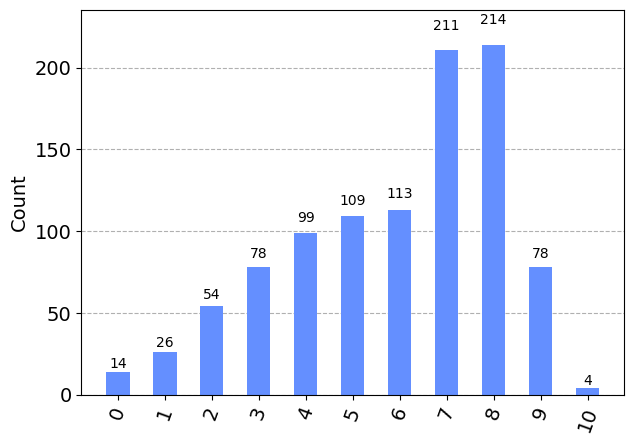

In [2]:
from qiskit import QuantumCircuit
from qiskit_cold_atom.spins.spins_gate_library import OATGate
from qiskit.visualization import plot_histogram

qc = QuantumCircuit(1)

qc.append(OATGate(chi=0.4, delta=-1., omega=2.), qargs=[0])

# alternatively append the OAT gate directly:
# qc.oat(chi=0.4, delta=-1., omega=2., wire=0)

qc.measure_all()

# simulate the circuit with a spin length L=5
counts = backend.run(qc, spin=5).result().get_counts()
# convert counts to integers for better formatting
plot_histogram({int(k):v for k,v in counts.items()})

This gate creates a complicated superposition of the individual levels of the collective spin.

Similar to the [fermionic gateset](./03_fermionic_tweezer_hardware.ipynb) built up from Fermi-Hubbard interactions, we can separate the different terms in the one-axis-twisting Hamiltonian to define gates with a more refined behaviour:

- An `RLXGate` with unitary $U_{\text{LX}}(\Omega) = U_{\text{OAT}}(\chi=0, \Delta=0, \Omega)$ describing rotations around the collective spin's x-axis
- A `RLZGate` with unitary $U_{\text{LZ}}(\Delta) = U_{\text{OAT}}(\chi=0, \Delta, \Omega=0)$ describing rotations around the collective spin's z-axis
- A `RLZ2Gate` with unitary $U_{\text{LZ2}}(\chi) = U_{\text{OAT}}(\chi, \Delta=0, \Omega=0)$ describing a non-linear "spin-squeezing" dynamic

These gates are available as `SpinGates` from the `spin_gate_library`. As detailed in the introduction notebook, these gates have their generating Hamiltonians defined as a `SpinOp`:

In [3]:
from qiskit_cold_atom.spins.spins_gate_library import RLXGate, RLZGate, RLZ2Gate
print("LX generator: \n", RLXGate(0.5).generator)
print("LZ generator: \n", RLZGate(1.).generator)
print("LZ2 generator: \n", RLZ2Gate(1.5).generator)

LX generator: 
 Spin Operator
spin=1/2, number spins=1, number terms=1
  0.5 * ( X_0 )
LZ generator: 
 Spin Operator
spin=1/2, number spins=1, number terms=1
  1.0 * ( Z_0 )
LZ2 generator: 
 Spin Operator
spin=1/2, number spins=1, number terms=1
  1.5 * ( Z_0^2 )


#### Rabi oscillations:

The `LXGate` is sufficient to generate Rabi-oscillations of individual collective spins. For Rabi oscilattions, we create a list of circuits with increasing angles $\Omega$ in the LX-gate used above. These can be sent to the backend in a single job:

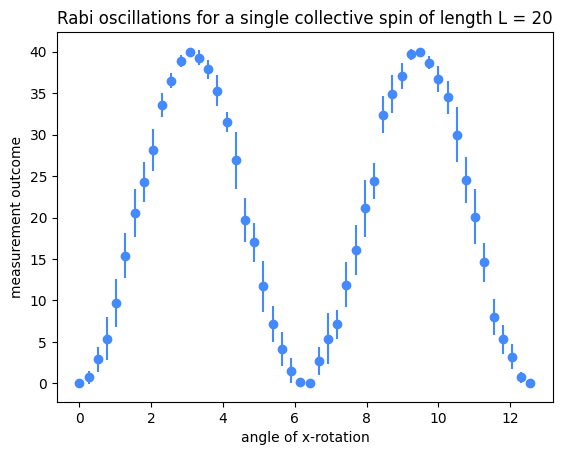

In [4]:
from qiskit.circuit import Parameter
import matplotlib.pyplot as plt
import numpy as np

# lenght of spin for the simulation
spin = 20

# sample at 50 angles between 0 and 4*pi
vals = 50
angles = np.linspace(0, 4*np.pi, vals)

omega = Parameter("omega")
# create list of circuits
circuit = QuantumCircuit(1, 1)
circuit.rlx(omega, 0)
circuit.measure(0, 0)

rabi_list = [circuit.assign_parameters([angle]) for angle in angles]

job_rabi = backend.run(rabi_list, shots = 10, spin = spin, seed=5462)
result_rabi = job_rabi.result()

outcomes = np.array([np.array(result_rabi.get_memory(i), dtype=float) for i in range(vals)])
plt.errorbar(angles, np.mean(outcomes, axis=1), yerr=np.std(outcomes, axis=1), fmt='o', color="#4589ff")
plt.title(f"Rabi oscillations for a single collective spin of length L = {spin}")
plt.ylabel("measurement outcome")
plt.xlabel("angle of x-rotation")
plt.show()

The `LXGate` takes the collective spin from its initial position at $\left| 0 \right>$ all the way to its maximum value $\left| 2L \right>$ and back. In between, the errorbars on the measurement outcomes are larger indicating a larger spread in the measurement distributions. As we saw in the introduction to spin circuits tutorial, this is due to the binomial distribution of measurement outcomes generated by a single rotation. 

This spread can be decreased by a phenomenom called [spin squeezing](https://en.wikipedia.org/wiki/Spin_squeezing), which can be engineered with the `LZ2Gate2`. In a spin-squeezed state, the variance in one spin projection is reduced at the cost of increasing the spread in another spin direction. This can be useful for quantum metrology applications [3]. 

#### Spin squeezing

To observe spin squeezing, we implement the following sequence: 
- The state is rotated onto the y-axis by the LX gate. 
- This state is spin-squeezed by applying LZ2.
- To "see" the squeezing in the computational ($L_z$) basis we rotate the squeezed state along the y-axis which is done by a z- and x-rotation

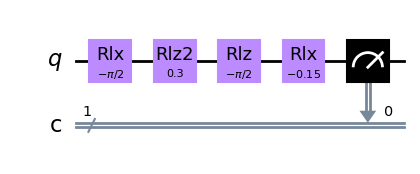

In [5]:
# circuit with spin squeezing
squeez_circ = QuantumCircuit(1, 1)
squeez_circ.rlx(-np.pi/2, 0)
squeez_circ.rlz2(0.3, 0)
squeez_circ.rlz(-np.pi/2, 0)
squeez_circ.rlx(-0.15, 0)
squeez_circ.measure(0, 0)

job_squeez = backend.run(squeez_circ, shots = 1000, spin=20, seed=14)

squeez_circ.draw(output='mpl', style="clifford")

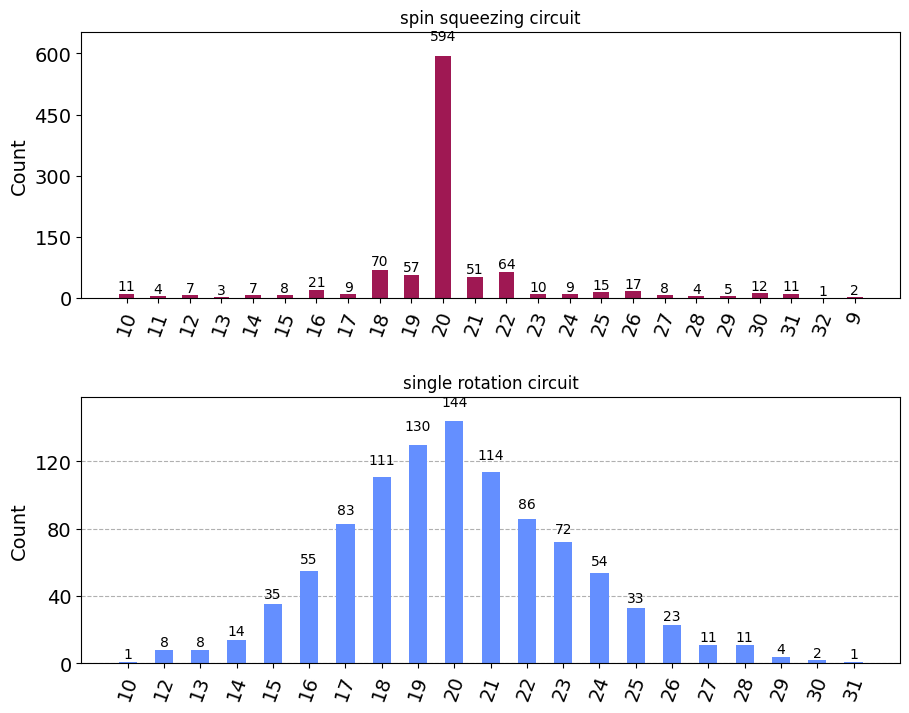

In [6]:
# for comparison: circuit with a single rotation
circ_x = QuantumCircuit(1, 1)
circ_x.rlx(np.pi/2, 0)
circ_x.measure_all()

job_x = backend.run(circ_x, shots = 1000, spin=20, seed=14)

fig, (ax1, ax2) = plt.subplots(2, figsize=(10,8))
fig.tight_layout(pad=5.0)
ax1.set_title("spin squeezing circuit")
ax2.set_title("single rotation circuit")

plot_histogram(job_squeez.result().get_counts(), ax=ax1, color="#9f1853") #, number_to_keep=10)
plot_histogram(job_x.result().get_counts(), ax=ax2) #, number_to_keep=10)

The spin squeezing generated by the $LZ2$-gate is a vital tool in this architecture to amplify the amplitude of a target state, such as "20" in the above example. 

#### Multiple-spin gates

Interactions between the collective spins in the individual tweezers can be mediated through collisions with a second species of atoms present in an overlapping trap [1]. In the setting we employ here, this results in an interaction which implements the spin-analogue of a ZZ-rotation with a generating Hamiltonian

$$ H_{int}(\gamma) = \gamma L_{z, i} L_{z, j} $$

where $i$ and $j$ are the indices of the coupled tweezers. This can be used to create entanglement between two collective spins:

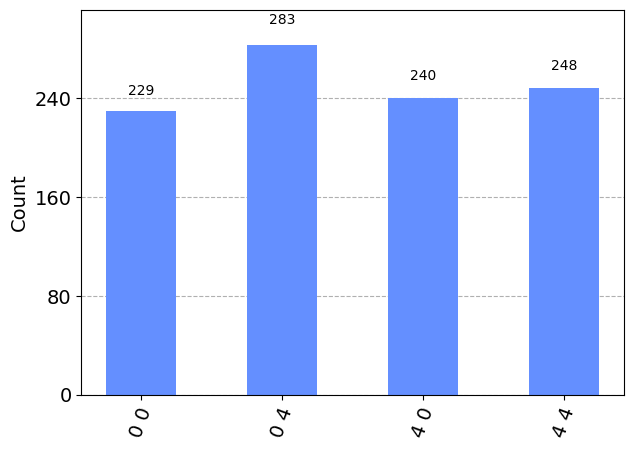

In [7]:
from qiskit_cold_atom.spins.spins_gate_library import RLZLZGate

qc = QuantumCircuit(2)

qc.rlx(np.pi/2, [0, 1])
qc.rlzlz(np.pi, [0, 1])
qc.rlx(np.pi/2, [0, 1])

qc.measure_all()

plot_histogram(backend.run(qc, spin=2).result().get_counts())

The state we have created here can be seen as the generalization of a Bell state of two qubits, which we can verify if we run the simulation with a single atom, i.e. spin length $\frac{1}{2}$:

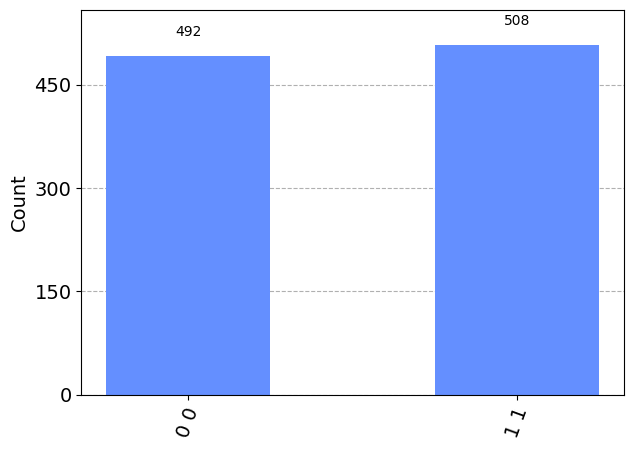

In [8]:
plot_histogram(backend.run(qc, spin=1/2).result().get_counts())

## Description as a backend

The framework describing the collective spin hardware is implemented as a dedicated _backend_.

We could have also run the circuits above on the generic `SpinSimulator` backend. However, by defining a specific `CollectiveSpinSimulator` backend, we have a direct way of describing the accepted gates, size and other settings of this specific system in the backend's _configuration_. 

The backend configuration explicitly states which instructions are accepted and in what way these instructions can be applied to the spin register. The latter is achieved through _coupling maps_ which define the accepted wiring for all gates. For reference, here is the entire configuration of the `CollectiveSpinSimulator`:

In [9]:
from pprint import pprint

collective_spins_configuration = backend.configuration().to_dict()

pprint(collective_spins_configuration)

{'atomic_species': ['na'],
 'backend_name': 'collective_spin_simulator',
 'backend_version': '0.0.1',
 'basis_gates': ['rlx', 'rly', 'rlz', 'rlz2', 'OAT', 'rlzlz', 'rlxly'],
 'cold_atom_type': 'spin',
 'conditional': False,
 'coupling_map': None,
 'description': 'simulator of a collective hardware. Each wire in the circuit '
                'denotes the orientation of one collective spin in the '
                'hardware',
 'dynamic_reprate_enabled': False,
 'gates': [{'coupling_map': [[0], [1], [2]],
            'description': 'local rotation of the coherent spin around x',
            'name': 'rlx',
            'parameters': ['omega'],
            'qasm_def': 'gate rlx(omega) {}'},
           {'coupling_map': [[0], [1], [2]],
            'description': 'local rotation of the coherent spin around y',
            'name': 'rly',
            'parameters': ['delta'],
            'qasm_def': 'gate rly(delta) {}'},
           {'coupling_map': [[0], [1], [2]],
            'description': 'lo

Note how each gate has a custom coupling map which defines the allowed wire indices with which the gate can be added to the circuit.

Apart from that, the `CollectiveSpinSimulator` inherits all functionality of the generic `SpinSimulator` such as retrieving the statevector and the unitary.

## Outlook

The collective spin simulator backend can be used as a tool to study what kind of quantum computations can be performed in a realistic experimental hardware based on spins as the carriers of quantum information. This collective spin setting is particularly interesting as its gateset forms a universal set on the Hilbert space of the collective spins and could implement error correction when encoding a qubit in each collective spin [2].

The supported functionality for spin circuits in Qiskit-cold-atom can in principle be utilized to describe a larger class of spin setups, i.e. other trap- or lattice-based architectures that can deterministically prepare, manipulate and measure individual spins encoded in bosonic atoms. Such experiments might have different underlying Hamiltonian dynamics, number of atomic species, available gates and coupling maps. 

This tutorial is just one example showing how Qiskit can be used to build a backend for a specific experimental setting that greatly differs from superconducting-qubit-based quantum computers. 

Interested users are encouraged to explore spin circuits and backend configurations for other setups.

## References
[1] Gross, Christian *Spin squeezing, entanglement and quantum metrology with Bose–Einstein condensates* Journal of Physics B: Atomic, Molecular and Optical Physics. 45 (10):103001

[2] Kasper, Valentin et al., *Universal quantum computation and quantum error correction with ultracold atomic mixtures*, arXiv preprint arXiv:2010.15923, 2020

[3] Strobel, Helmut et al. *Fisher information and entanglement of non-Gaussian spin states*, Science, 345(6195):424–427, 2014

In [10]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright